#Import Libraries

In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

#Preproccess the dataset

In [ ]:
import os, shutil, numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

class CustomDataset(Dataset):
    def __init__(self, root, data, transformations = None):
        self.transformations = transformations
        self.im_paths = sorted(glob(f"{root}/{data}/*/*"))
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0

        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

    def get_class(self, path):
        return os.path.dirname(path).split("/")[-1]

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]
        if self.transformations is not None:
            im = self.transformations(im)
        return im, gt

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):

    tr_ds = CustomDataset(root = root, data = "train", transformations = transformations)
    vl_ds = CustomDataset(root = root, data = "valid",transformations = transformations)
    ts_ds = CustomDataset(root = root, data = "test",transformations = transformations)

    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns,pin_memory=True), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns,pin_memory=True)

    return tr_dl, val_dl, ts_dl, tr_ds.cls_names

root = "/content/drive/MyDrive/cards2"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 36)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

74
8
265
{'ace of clubs': 0, 'ace of diamonds': 1, 'ace of hearts': 2, 'ace of spades': 3, 'eight of clubs': 4, 'eight of diamonds': 5, 'eight of hearts': 6, 'eight of spades': 7, 'five of clubs': 8, 'five of diamonds': 9, 'five of hearts': 10, 'five of spades': 11, 'four of clubs': 12, 'four of diamonds': 13, 'four of hearts': 14, 'four of spades': 15, 'jack of clubs': 16, 'jack of diamonds': 17, 'jack of hearts': 18, 'jack of spades': 19, 'joker': 20, 'king of clubs': 21, 'king of diamonds': 22, 'king of hearts': 23, 'king of spades': 24, 'nine of clubs': 25, 'nine of diamonds': 26, 'nine of hearts': 27, 'nine of spades': 28, 'queen of clubs': 29, 'queen of diamonds': 30, 'queen of hearts': 31, 'queen of spades': 32, 'seven of clubs': 33, 'seven of diamonds': 34, 'seven of hearts': 35, 'seven of spades': 36, 'six of clubs': 37, 'six of diamonds': 38, 'six of hearts': 39, 'six of spades': 40, 'ten of clubs': 41, 'ten of diamonds': 42, 'ten of hearts': 43, 'ten of spades': 44, 'three o

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool_2(self.relu(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.pool_2(self.relu(self.conv3(x)))
        x = self.relu(self.conv4(x))
        x = self.pool_2(self.relu(self.conv5(x)))
        x = x.view(-1, 256 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Initialize the model
model = CustomCNN(num_classes=53)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=53, bias=True)
  (relu): ReLU()
)

#Train Model

In [ ]:
from tqdm import tqdm

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    # Training phase
    model.train()  # training mode
    running_loss = 0.0

    # Wrap the training data loader with tqdm
    with tqdm(total=len(tr_dl)) as pbar:
        for i, (inputs, labels) in enumerate(tr_dl, 0):
            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(inputs.to(device))

            # Calculate loss
            loss = criterion(outputs, labels.to(device))

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update tqdm progress bar
            pbar.update(1)
            pbar.set_description(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / (i + 1):.4f}")

    # Validation phase
    model.eval()  # evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_dl:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    # Calculate accuracy
    val_accuracy = correct / total

    # Print statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Training Loss: {running_loss / len(tr_dl):.4f}, '
          f'Validation Accuracy: {100 * val_accuracy:.2f}%')

print('Finished Training')

Epoch [1/20], Training Loss: 3.6363: 100%|██████████| 74/74 [14:06<00:00, 11.44s/it]


Epoch [1/20], Training Loss: 3.6363, Validation Accuracy: 18.87%


Epoch [2/20], Training Loss: 2.3016: 100%|██████████| 74/74 [13:52<00:00, 11.25s/it]


Epoch [2/20], Training Loss: 2.3016, Validation Accuracy: 44.53%


Epoch [3/20], Training Loss: 1.5451: 100%|██████████| 74/74 [13:30<00:00, 10.96s/it]


Epoch [3/20], Training Loss: 1.5451, Validation Accuracy: 54.34%


Epoch [4/20], Training Loss: 0.9324: 100%|██████████| 74/74 [14:04<00:00, 11.42s/it]


Epoch [4/20], Training Loss: 0.9324, Validation Accuracy: 62.26%


Epoch [5/20], Training Loss: 0.5169: 100%|██████████| 74/74 [13:48<00:00, 11.19s/it]


Epoch [5/20], Training Loss: 0.5169, Validation Accuracy: 66.04%


Epoch [6/20], Training Loss: 0.2962: 100%|██████████| 74/74 [13:57<00:00, 11.32s/it]


Epoch [6/20], Training Loss: 0.2962, Validation Accuracy: 67.55%


Epoch [7/20], Training Loss: 0.2143: 100%|██████████| 74/74 [14:23<00:00, 11.67s/it]


Epoch [7/20], Training Loss: 0.2143, Validation Accuracy: 68.68%


Epoch [8/20], Training Loss: 0.1481: 100%|██████████| 74/74 [14:00<00:00, 11.36s/it]


Epoch [8/20], Training Loss: 0.1481, Validation Accuracy: 63.77%


Epoch [9/20], Training Loss: 0.1379: 100%|██████████| 74/74 [14:33<00:00, 11.81s/it]


Epoch [9/20], Training Loss: 0.1379, Validation Accuracy: 67.17%


Epoch [10/20], Training Loss: 0.0958: 100%|██████████| 74/74 [15:42<00:00, 12.73s/it]


Epoch [10/20], Training Loss: 0.0958, Validation Accuracy: 70.94%


Epoch [11/20], Training Loss: 0.0826: 100%|██████████| 74/74 [15:43<00:00, 12.75s/it]


Epoch [11/20], Training Loss: 0.0826, Validation Accuracy: 70.57%


Epoch [12/20], Training Loss: 0.0610: 100%|██████████| 74/74 [15:15<00:00, 12.37s/it]


Epoch [12/20], Training Loss: 0.0610, Validation Accuracy: 70.19%


Epoch [13/20], Training Loss: 0.0236: 100%|██████████| 74/74 [15:15<00:00, 12.37s/it]


Epoch [13/20], Training Loss: 0.0236, Validation Accuracy: 73.96%


Epoch [14/20], Training Loss: 0.0330: 100%|██████████| 74/74 [14:57<00:00, 12.13s/it]


Epoch [14/20], Training Loss: 0.0330, Validation Accuracy: 70.57%


Epoch [15/20], Training Loss: 0.0322: 100%|██████████| 74/74 [15:07<00:00, 12.26s/it]


Epoch [15/20], Training Loss: 0.0322, Validation Accuracy: 73.96%


Epoch [16/20], Training Loss: 0.0197: 100%|██████████| 74/74 [15:09<00:00, 12.29s/it]


Epoch [16/20], Training Loss: 0.0197, Validation Accuracy: 71.32%


Epoch [17/20], Training Loss: 0.0064: 100%|██████████| 74/74 [15:09<00:00, 12.29s/it]


Epoch [17/20], Training Loss: 0.0064, Validation Accuracy: 72.83%


Epoch [18/20], Training Loss: 0.0052: 100%|██████████| 74/74 [14:57<00:00, 12.12s/it]


Epoch [18/20], Training Loss: 0.0052, Validation Accuracy: 74.34%


Epoch [19/20], Training Loss: 0.0039: 100%|██████████| 74/74 [15:16<00:00, 12.39s/it]


Epoch [19/20], Training Loss: 0.0039, Validation Accuracy: 72.83%


Epoch [20/20], Training Loss: 0.0031: 100%|██████████| 74/74 [15:09<00:00, 12.29s/it]


Epoch [20/20], Training Loss: 0.0031, Validation Accuracy: 74.72%
Finished Training


#Save Model

In [ ]:
torch.save(model, 'model.pth')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define your custom model class (replace this with your actual custom model class)
class CustomModel(nn.Module):
    def __init__(self, num_classes=54):
        super(CustomModel, self).__init__()
        self.layer1 = nn.Linear(1024, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Instantiate the model
model = CustomModel(num_classes=52)

In [ ]:
import torch

# Load the entire model directly
model = torch.load('/content/model.pth')
model.eval()  # Set model to evaluation mode

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

<ipython-input-56-c954307087c4>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/model.pth')


#Evaluate Model

In [ ]:
from sklearn.metrics import precision_score, recall_score
import time

# Initialize counters
correct = 0
total = 0
all_labels = []
all_predictions = []
total_inference_time = 0

# Evaluate the model
with torch.no_grad():
    for data in ts_dl:  # Assuming ts_dl is your test DataLoader
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Measure inference time
        start_time = time.time()
        outputs = model(images)
        inference_time = time.time() - start_time
        total_inference_time += inference_time

        # Get predictions and update accuracy count
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect labels and predictions for precision and recall calculation
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate Accuracy
accuracy = 100 * correct / total
print(f'Accuracy on the test images: {accuracy:.2f}%')

# Calculate Precision and Recall
precision = precision_score(all_labels, all_predictions, average='weighted') * 100
recall = recall_score(all_labels, all_predictions, average='weighted') * 100
print(f'Precision on the test images: {precision:.2f}%')
print(f'Recall on the test images: {recall:.2f}%')

# Calculate Speed (average inference time per image)
average_inference_time = total_inference_time / total  # total number of images
print(f'Average inference time per image: {average_inference_time:.4f} seconds')

# Summary of Metrics
print("\nPerformance Metrics Summary:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"Speed (Average Inference Time per Image): {average_inference_time:.4f} seconds")

Accuracy on the test images: 72.08%
Precision on the test images: 76.78%
Recall on the test images: 72.08%
Average inference time per image: 0.1476 seconds

Performance Metrics Summary:
Accuracy: 72.08%
Precision: 76.78%
Recall: 72.08%
Speed (Average Inference Time per Image): 0.1476 seconds


#Testing Uploaded Imange

In [ ]:
# Define transformations
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
transform = T.Compose([
    T.Resize((im_size, im_size)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

In [ ]:
def load_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)

In [ ]:
def predict(image_path, model, class_names):
    # Load and preprocess the image
    image = load_image(image_path)

    # Make predictions
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_class = probabilities.argmax(dim=1).item()
        confidence = probabilities.max().item() * 100

    # Display the result
    print(f"Predicted Class: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.2f}%")


Predicted class index: 12
Number of classes: 53


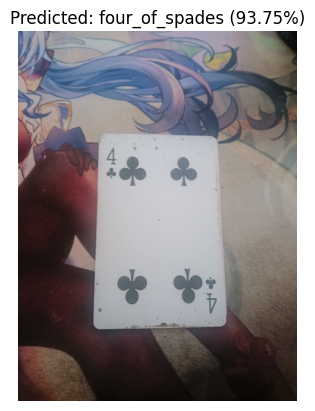

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms as T
from PIL import Image

# Define transformations
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
transform = T.Compose([
    T.Resize((im_size, im_size)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# Load the image with transformations
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_transformed = transform(image).unsqueeze(0)  # Add batch dimension
    return image, image_transformed.to(device)

def predict_and_plot(image_path, model, class_names):
    # Load and preprocess the image
    original_image, image_tensor = load_image(image_path)

    # Make predictions
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_class = probabilities.argmax(dim=1).item()
        confidence = probabilities.max().item() * 100

    # Debug: Check predicted_class and class_names length
    print(f"Predicted class index: {predicted_class}")
    print(f"Number of classes: {len(class_names)}")

    # Plot the image with prediction
    if predicted_class < len(class_names):
        plt.imshow(original_image)
        plt.axis('off')
        plt.title(f"Predicted: {class_names[predicted_class]} ({confidence:.2f}%)")
        plt.show()
    else:
        print(f"Error: Predicted class index {predicted_class} is out of range for class names.")

# Define class names (ensure this matches your dataset)
class_names = ['ace_of_spades', 'ace_of_hearts', 'ace_of_diamonds', 'ace_of_clubs',
    'two_of_spades', 'two_of_hearts', 'two_of_diamonds', 'two_of_clubs',
    'three_of_spades', 'three_of_hearts', 'three_of_diamonds', 'three_of_clubs',
    'four_of_spades', 'four_of_hearts', 'four_of_diamonds', 'four_of_clubs',
    'five_of_spades', 'five_of_hearts', 'five_of_diamonds', 'five_of_clubs',
    'six_of_spades', 'six_of_hearts', 'six_of_diamonds', 'six_of_clubs',
    'seven_of_spades', 'seven_of_hearts', 'seven_of_diamonds', 'seven_of_clubs',
    'eight_of_spades', 'eight_of_hearts', 'eight_of_diamonds', 'eight_of_clubs',
    'nine_of_spades', 'nine_of_hearts', 'nine_of_diamonds', 'nine_of_clubs',
    'ten_of_spades', 'ten_of_hearts', 'ten_of_diamonds', 'ten_of_clubs',
    'jack_of_spades', 'jack_of_hearts', 'jack_of_diamonds', 'jack_of_clubs',
    'queen_of_spades', 'queen_of_hearts', 'queen_of_diamonds', 'queen_of_clubs',
    'king_of_spades', 'king_of_hearts', 'king_of_diamonds', 'king_of_clubs',
    'joker']  # Add all class names

# Run prediction and plot the result
image_path = "/content/IMG20241103123308.jpg"  # Path to the test image
predict_and_plot(image_path, model, class_names)